In [1]:
import os
import re
import sys
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

import pickle

if '..' not in sys.path:
    sys.path.append('..')
from pfcommon import build_network_graph, make_full_object_name, get_objects

In [2]:
data_file = 'nine-bus_graph'
data_file = 'sardinia_graph'
force = False

if force or not os.path.isfile(data_file + '.pkl'):
    powerfactory_path = r'C:\Program Files\DIgSILENT\PowerFactory 2023 SP2\Python\3.10'
    if powerfactory_path not in sys.path:
        sys.path.append(powerfactory_path)
    import powerfactory as pf

    if data_file == 'nine-bus_graph':
        project_name = '\\Terna_Inerzia\\Nine-bus System'
    elif data_file == 'sardinia_graph':
        project_name = '\\Terna_Inerzia\\V2020_Rete_Sardegna_2021_06_03cr'
    else:
        raise Exception('Unknown data file name')

    app = pf.GetApplication()
    if app is None:
        raise Exception('Cannot get PowerFactory application')
    print('Got PowerFactory application.')
    
    err = app.ActivateProject(project_name)
    if err:
        raise Exception(f'Cannot activate project {project_name}')
    print(f'Activated project "{project_name}".')
    
    _,named_weighted_edges,nodes,terminals,lines,switches,\
        trans2,trans3,loads,SMs,SGs,shunts = build_network_graph(app, use='nodes', weighted=True,
                                                                 full_output=True, verbose=True)

    get_names = lambda objs: [make_full_object_name(obj) for obj in objs]
    line_names     = get_names(lines)
    trans2_names   = get_names(trans2)
    trans3_names   = get_names(trans3)
    switch_names   = get_names(switches)
    load_names     = get_names(loads)
    SM_names       = get_names(SMs)
    SG_names       = get_names(SGs)
    shunt_names    = get_names(shunts)
    terminal_names = get_names(terminals)

    data = {
        'named_weighted_edges': named_weighted_edges,
        'nodes': nodes,
        'line_names': line_names,
        'trans2_names': trans2_names,
        'trans3_names': trans3_names,
        'switch_names': switch_names,
        'load_names': load_names,
        'SM_names': SM_names,
        'SG_names': SG_names,
        'shunt_names': shunt_names,
        'terminal_names': terminal_names
    }
    pickle.dump(data, open(data_file + '.pkl', 'wb'))
    
else:
    data = pickle.load(open(data_file + '.pkl', 'rb'))
    named_weighted_edges = data['named_weighted_edges']
    nodes                = data['nodes']
    line_names           = data['line_names']
    trans2_names         = data['trans2_names']
    trans3_names         = data['trans3_names']
    switch_names         = data['switch_names']
    load_names           = data['load_names']
    SM_names             = data['SM_names']
    SG_names             = data['SG_names']
    shunt_names          = data['shunt_names']
    terminal_names       = data['terminal_names']

In [3]:
n_terminals = len(terminal_names)
n_lines, n_switches, n_trans2, n_trans3 = len(line_names), len(switch_names), len(trans2_names), len(trans3_names)
n_loads, n_SMs, n_SGs, n_shunts = len(load_names), len(SM_names), len(SG_names), len(shunt_names)
print('No. of terminals: {}'.format(n_terminals))
print('No. of lines: {}'.format(n_lines))
print('No. of switches: {}'.format(n_switches))
print('No. of 2-winding transformers: {}'.format(n_trans2))
print('No. of 3-winding transformers: {}'.format(n_trans3))
print('No. of loads: {}'.format(n_loads))
print('No. of SMs: {}'.format(n_SMs))
print('No. of SGs: {}'.format(n_SGs))
print('No. of shunts: {}'.format(n_shunts))

No. of terminals: 2657
No. of lines: 222
No. of switches: 1798
No. of 2-winding transformers: 113
No. of 3-winding transformers: 2
No. of loads: 193
No. of SMs: 18
No. of SGs: 42
No. of shunts: 6


In [4]:
weighted_edges = [(a,b,l) for a,b,n,l,v in named_weighted_edges]
weighted_graph = nx.MultiGraph()
for a,b,n,l,v in named_weighted_edges:
    weighted_graph.add_edge(a, b, weight=l, label=n, voltage=v)
# weighted_graph.add_weighted_edges_from(weighted_edges, weight='length', voltage=voltages)
# nx.set_edge_attributes(weighted_graph, voltages, 'voltage')
voltages = np.unique([v for a,b,n,l,v in named_weighted_edges])[::-1]
lengths = np.unique([l for a,b,n,l,v in named_weighted_edges])[::-1]

graph = nx.MultiGraph()
graph.add_edges_from([(a,b) for a,b,w in weighted_edges])

n_nodes = len(graph.nodes)
n_edges = len(graph.edges)
n_cc = nx.number_connected_components(weighted_graph)
print('The graph is{} connected.'.format('' if nx.is_connected(graph) else ' not'))
print('No. of nodes: {}'.format(n_nodes))
print('No. of edges: {}'.format(n_edges))
print('No. of connected components: {}'.format(n_cc))
#print('Voltage levels: [{}] kV'.format(', '.join(map(lambda w: f'{w:g}', weights))))

The graph is connected.
No. of nodes: 2083
No. of edges: 2121
No. of connected components: 1


In [5]:
layout_algo = 'kamada_kawai'
weighted_pos = False
pos_file = data_file + '_' + layout_algo + '_layout'
pos_file += '_weighted.pkl' if weighted_pos else '.pkl'
print('Output file: {}'.format(pos_file))
force = False
if not os.path.isfile(pos_file) or force:
    sys.stdout.write('Computing graph layout... ')
    sys.stdout.flush()
    if layout_algo == 'kamada_kawai':
        # takes forever using the weighted graph
        pos = nx.kamada_kawai_layout(weighted_graph if weighted_pos else graph)
    elif layout_algo == 'spring':
        pos = nx.spring_layout(weighted_graph if weighted_pos else graph, seed=1983)
    else:
        raise Exception('Unknown layout algorithm: `{}`'.format(layout_algo))
    sys.stdout.write('done.\n')
    pickle.dump(pos, open(pos_file, 'wb'))
else:
    pos = pickle.load(open(pos_file, 'rb'))

Output file: sardinia_graph_kamada_kawai_layout.pkl


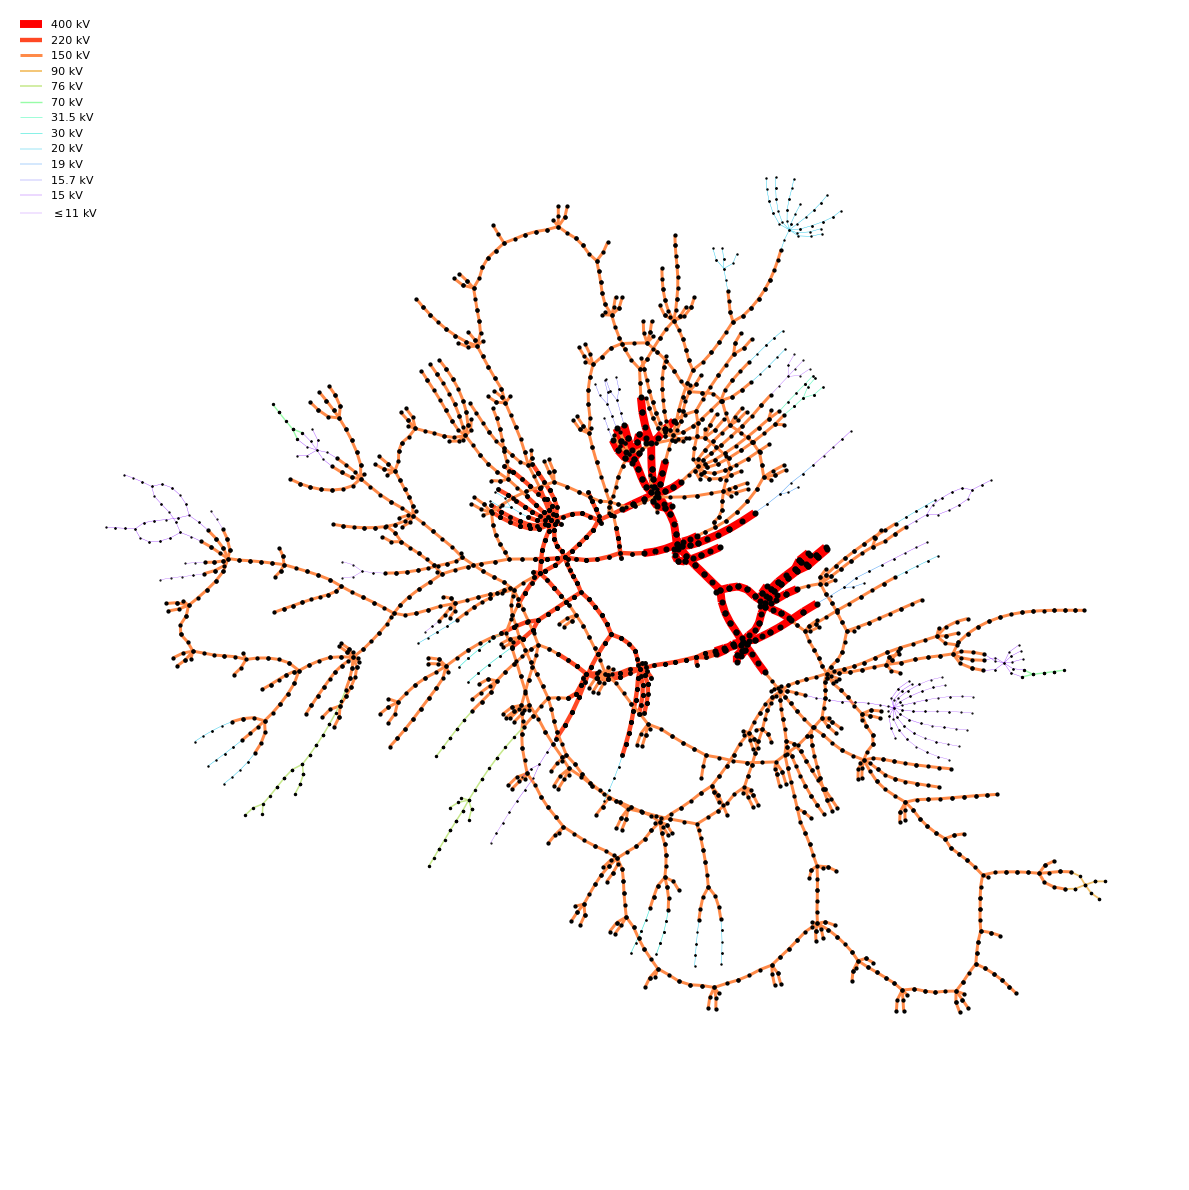

In [6]:
Vmin = 12
cmap = plt.get_cmap('rainbow_r', (voltages>Vmin).sum())
fig,ax = plt.subplots(1, 1, figsize=(12,12))
# labels = {n: n.split('|')[-1].split('__')[0] for n in graph.nodes if 'FSACT' in n}
# nx.draw_networkx_labels(graph, pos, labels=labels, font_size=6, ax=ax)
for i,V in enumerate(voltages):
    if V >= Vmin:
        idx = [(a,b) for a,b,d in weighted_graph.edges(data=True) if d['voltage'] == V]
        lbl = '{:g} kV'.format(V)
    else:
        idx = [(a,b) for a,b,d in weighted_graph.edges(data=True) if d['voltage'] <= V]
        lbl = r'$\leq{:g}$ kV'.format(V)
#     wdt = np.log(V) / np.log(7)
    wdt = V / 70
    nx.draw_networkx_nodes(weighted_graph.subgraph([jdx[0] for jdx in idx]), pos,
                           node_color='k', node_size=wdt*2, ax=ax)
    nx.draw_networkx_nodes(weighted_graph.subgraph([jdx[1] for jdx in idx]), pos,
                           node_color='k', node_size=wdt*2, ax=ax)
    nx.draw_networkx_edges(weighted_graph, pos, edgelist=idx, width=wdt, edge_color=cmap(i), label=lbl, ax=ax)
    if V < Vmin:
        break
ax.axis('off')
ax.axis('equal')
ax.legend(loc='upper left', frameon=False, fontsize=8)
fig.tight_layout()
plt.savefig(data_file + '.pdf')

### Same edge connecting more than two nodes

### A former cycle